# Visualization Experiments

Lets load the data artefacts to local memory. These files are to be downloaded from S3 as the pipeline automatically uploads them to the pre-configured S3 bucket.

In [18]:
from file_utilities import download_files
import pickle

# Download files from S3 bucket. You can download multiple files at a time by passing a list of names
# files_to_download = ["df.pkl",
#                      "mappings.pkl",
#                      "transcript_timestamps.txt"]

# set the timestamp 
timestamp = "06-23-2023_06:10:03"

# df,mappings,transcript_timestamps file names
df_file_name = "df_" + timestamp + ".pkl"
mappings_file_name = "mappings_" + timestamp + ".pkl"
transcript_file_name = "transcript_with_timestamp_" + timestamp + ".txt"


files_to_download = [df_file_name,
                    mappings_file_name,
                    transcript_file_name] 
download_files(files_to_download)

2023-06-23 15:01:36.558 | INFO     | file_utilities:download_files:36 - Downloading file df_06-23-2023_06:10:03.pkl
2023-06-23 15:01:38.450 | INFO     | file_utilities:download_files:36 - Downloading file mappings_06-23-2023_06:10:03.pkl
2023-06-23 15:01:39.179 | INFO     | file_utilities:download_files:36 - Downloading file transcript_with_timestamp_06-23-2023_06:10:03.txt


In [19]:
# Download spacy model for the first time
import nltk
import spacy
from nltk.corpus import stopwords

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
spaCy_model = "en_core_web_md"
nlp = spacy.load(spaCy_model)
spacy_stopwords = nlp.Defaults.stop_words
STOPWORDS = set(spacy_stopwords).union(set(stopwords.words('english')))

## Example template 1

## Scatter plot of transcription with Topic modelling

In [23]:

df = pd.read_pickle(df_file_name)
df

,timestamp,text,ts_to_topic_mapping_top_1,ts_to_topic_mapping_top_2
0,"(0.0, 12.36)","this . Okay , yeah , so it looks like I am re...",TAM,Founders
1,"(12.36, 25.76)",because Goku needs that for the audio plus the...,Founders,TAM
2,"(25.76, 30.32)",the rest of the team did . So I want to just ...,Founders,AGENDA
3,"(30.32, 35.52)",then we can ask questions or how do you want t...,TAM,Founders
4,"(35.52, 49.56)","introduction . So what I , it all started wit...",Founders,TAM
...,...,...,...,...
554,"(3323.0, 3326.56)",It 's crazy . But definitely with the,Founders,TAM
555,"(3326.56, 3332.24)","local models , we have n't found a way to work...",Founders,TAM
556,"(3332.24, 3337.2)",if you 'd have 90 minutes of audio to transfer...,TAM,Founders
557,"(3338.32, 3344.4)",We actually have a preprocessor to resolve wha...,Founders,TAM


Change the values of "category", "category_name" to one agenda topic and change the value of "not_category_name" and see different plots.

In [25]:
import pandas as pd
import scattertext as st

df = pd.read_pickle(df_file_name)

def plot_topic_modelling_and_word_to_sentence_search(df, cat_1, cat_1_name, cat_2_name):
    df = df.assign(parse=lambda df: df.text.apply(st.whitespace_nlp_with_sentences))

    corpus = st.CorpusFromParsedDocuments(
        df, category_col='ts_to_topic_mapping_top_1', parsed_col='parse'
    ).build().get_unigram_corpus().remove_terms(STOPWORDS, ignore_absences=True).compact(st.AssociationCompactor(2000))
    
    html = st.produce_scattertext_explorer(
        corpus,
        category=cat_1, category_name=cat_1_name, not_category_name=cat_2_name,
        minimum_term_frequency=0, pmi_threshold_coefficient=0,
        width_in_pixels=1000,
        transform=st.Scalers.dense_rank
    )
    open('./new_viz_' + timestamp + '.html', 'w').write(html)

plot_topic_modelling_and_word_to_sentence_search(df,
                                                cat_1="Founders",
                                                cat_1_name="Founders",
                                                cat_2_name="TAM")

# once you are done, check the generated HTML file


## Example template 2

## Time driven Insights

In [26]:
mappings = pickle.load(open(mappings_file_name, "rb"))
timestamp_to_topic_first_match = mappings[0]
timestamp_to_topic_second_match = mappings[1]
topic_to_timestamp_first_match = mappings[2]
topic_to_timestamp_second_match = mappings[3]

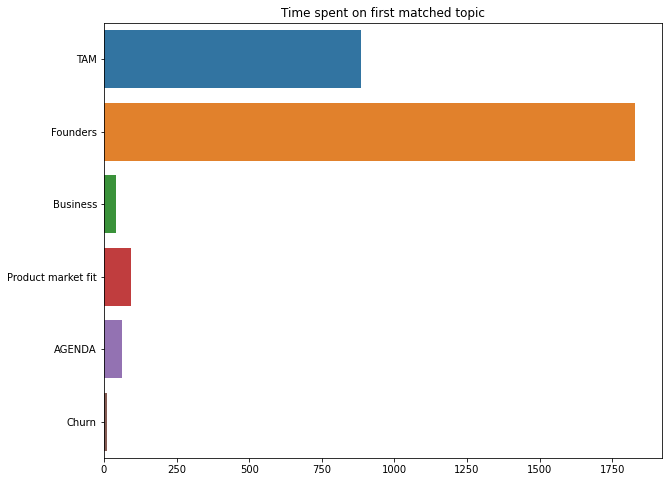

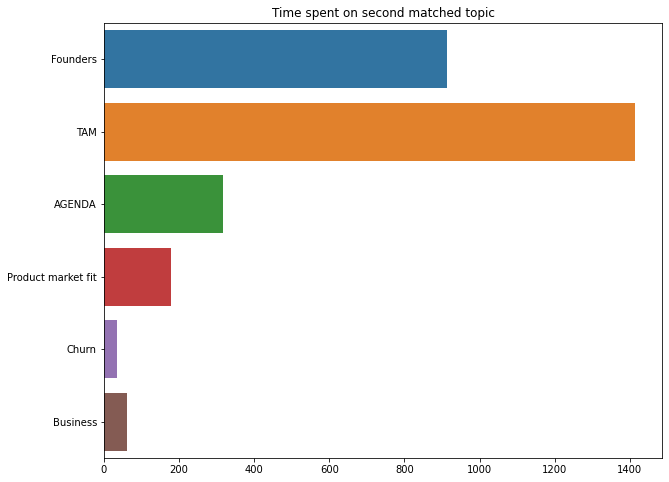

In [27]:
import collections 
import seaborn as sns
import matplotlib.pyplot as plt

def plot_time_spent_for_topic(mapping, order):
    topic_times = collections.defaultdict(int)
    for key in mapping.keys():
        if key[1] is None or key[0] is None:
            continue
        duration = key[1] - key[0]
        topic_times[mapping[key]] += duration
    
    keys = list(topic_times.keys())
    vals = [int(topic_times[k]) for k in keys]    
    plt.figure(figsize=(10,8))
    sns.barplot(x=vals, y=keys).set(title='Time spent on ' + order +  ' matched topic')

        

plot_time_spent_for_topic(timestamp_to_topic_first_match, "first")
plot_time_spent_for_topic(timestamp_to_topic_second_match, "second")

## Example template 3

## Enhanced search for timelines

We can already search for a particular word in the interactive HTML document from example 1 to see a list of all transcribed sentences having an occurence of the word (in the context of the chosen topic). 

We can also retrieve all the segments(timestamps)in the transcription, related to a particular topic, to

i) Segregrate all content on a particular topic of importance.

ii) Perform selective summarization of the segregated content to make productive follow-ups. (Maybe use a model to extract action items and announcements from the transcription or selective summary ? )

iii) Use the timestamps to highlight video / audio / transcription segments.

iv) Jump to a desired segment of video / audio / transcription.

In [28]:
def retrieve_time_segments(topic):
    return topic_to_timestamp_first_match[topic]

search_topic = "Founders"
print("Timelines where " + search_topic + " was covered : ")
time_segments_of_interest = retrieve_time_segments(topic=search_topic)
time_segments_of_interest

Timelines where Founders was covered : 


[(12.36, 25.76),
 (25.76, 30.32),
 (35.52, 49.56),
 (76.64, 87.76),
 (87.76, 96.08),
 (104.32, 105.62),
 (107.02, 111.0),
 (119.24, 123.14),
 (125.64, 130.64),
 (130.8, 132.6),
 (142.72, 145.24),
 (152.88, 155.14),
 (155.14, 157.8),
 (157.8, 160.96),
 (171.0, 188.68),
 (188.68, 197.28),
 (202.84, 214.48),
 (214.48, 219.28),
 (219.84, 228.44),
 (228.44, 238.76),
 (246.46, 248.84),
 (248.84, 251.38),
 (256.78, 259.5),
 (259.5, 261.94),
 (270.96, 278.4),
 (278.4, 288.32),
 (291.44, 293.84),
 (336.0, 339.12),
 (351.48, 352.32),
 (362.64, 393.44),
 (402.72, 403.04),
 (427.12, 432.12),
 (438.96, 441.34),
 (448.72, 453.84),
 (453.84, 463.36),
 (463.36, 466.5),
 (466.5, 468.26),
 (471.66, 473.06),
 (482.28, 487.6),
 (515.84, 522.64),
 (529.66, 533.24),
 (533.24, 535.52),
 (540.42, 543.16),
 (544.0, 550.0),
 (556.0, 564.0),
 (564.0, 568.76),
 (568.76, 569.6),
 (573.36, 574.56),
 (577.52, 580.96),
 (580.96, 584.6),
 (584.6, 605.62),
 (607.86, 609.18),
 (619.42, 621.54),
 (621.54, 623.98),
 (623.

## Selective segregation of content

In [31]:
import ast

time_segments_of_interest = retrieve_time_segments("Founders")

ts_transcript = {}
with open(transcript_file_name, "r") as f:
    ts_transcript = f.read()
ts_transcript = ast.literal_eval(ts_transcript)

selective_transcribed_content = ""
for chunk in ts_transcript["chunks"]:
    if chunk["timestamp"] in time_segments_of_interest:
        selective_transcribed_content += chunk["text"]

In [32]:
selective_transcribed_content

"because Goku needs that for the audio plus the transcript plus the timestamps .  So cool .  Okay , so we can have our discussion as planned about ontology prompt .  So JDC , I just wanted to learn about it and I think the rest of the team did .  So I want to just start off , maybe you want to give us some context and introduction .  So what I , it all started with the demo from Palantir. , as you know , they were able to make this AIP thing where they were such a powerful thing perhaps because they use an ontology .  So it means that they have a definition of entities and actions that they can take .  So then they control this to an LLM .  So I started exploring with that with Jamo . in our hierarchical way using just like texts . And it kind of works .  So in the end , I decided that one good pattern operations , mutations and queries over certain entities . So I assume that many of the LLMs have seen a lot of this data and know how to operate . So people from OpenAI and many compani

## Selective topic summarization

We can use this selective content to now summarize using the already available pipeline !

# And Much More !!